In [1]:
import sys
import os
import torch
import gpytorch
os.chdir("/home/kreffert/Probabilistic_LTSF/ProbTS")
from run import ProbTSCli
from probts.data import ProbTSBatchData
from probts.data import DataManager, ProbTSDataModule
from probts.utils import find_best_epoch
from probts.model.forecast_module import ProbTSForecastModule
from notebook.utils import plot_time_series, get_predictions, plot_qq_coverage

In [2]:
DATASET = 'etth1'
MODEL = 'patchtst_prob'
args={'config': f'config/ltsf/{DATASET}/{MODEL}.yaml', 
        'seed_everything':0,
       'data.data_manager.init_args.path': './datasets',
       'trainer.default_root_dir': './log_dir',
       'data.data_manager.init_args.dataset':f'{DATASET}',
       'data.data_manager.init_args.split_val': True,
       'trainer.max_epochs':50,
       'data.data_manager.init_args.context_length':96,
       'data.data_manager.init_args.prediction_length':96,
       'model.forecaster.no_training':True,
     'model.load_from_ckpt': "/home/kreffert/Probabilistic_LTSF/ProbTS/log_dir/etth1_PatchTST_prob_CTX96_PRED96_seed0/ckpt/",}

sys.argv = ['run.py']

sys.argv += [item for k, v in args.items() for item in (f'--{k}', str(v))]

cli = ProbTSCli(
        datamodule_class=ProbTSDataModule,
        model_class=ProbTSForecastModule,
        save_config_kwargs={"overwrite": True},
        run=False
    )
cli.init_exp(logging=False)
cli.set_test_mode()
cli.trainer.test(model=cli.model, datamodule=cli.datamodule)

[rank: 0] Seed set to 0
INFO:root:first/last timestamp found: 2016-07-01 00:00/2017-06-25 23:00
INFO:root:group training time series to datasets
INFO:root:first/last timestamp found: 2016-07-01 00:00/2017-10-23 23:00
INFO:root:group training time series to datasets
INFO:root:first/last timestamp found: 2016-07-01 00:00/2018-02-20 23:00
INFO:root:group training time series to datasets
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loading Long-term Dataset: etth1
val  pred_len: 96 : num_test_windows: 29
test  pred_len: 96 : num_test_windows: 29
Test context length: [96], prediction length: [96]
Validation context length: [96], prediction length: [96]
Training context length: [96], prediction lengths: [96]
Test rolling length: 96
Variable-specific normalization: True
sampling_weight_scheme: none


INFO:run:Loading pre-trained checkpoint from /home/kreffert/Probabilistic_LTSF/ProbTS/log_dir/etth1_PatchTST_prob_CTX96_PRED96_seed0/ckpt/epoch=49-val_CRPS=0.283364.ckpt


find best ckpt  epoch=49-val_CRPS=0.283364.ckpt
sampling_weight_scheme: none


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: |                                                                                                                                  | 1/? [00:07<00:00,  0.13it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       96_test_CRPS        │    0.30771809816360474    │
│     96_test_CRPS-Sum      │    0.22206513583660126    │
│       96_test_MASE        │     1.304531455039978     │
│        96_test_MSE        │    11.077550888061523     │
│      96_test_MSE-Sum      │    124.68760681152344     │
│        96_test_ND         │    0.4005759656429291     │
│      96_test_ND-Sum       │    0.2887555658817291     │
│       96_test_NRMSE       │    0.6984689235687256     │
│     96_test_NRMSE-Sum     │    0.38561052083969116    │
│    96_test_weighted_ND    │    0.4005759656429291     │
│  96_test_weighted_ND-Sum  │    0.2887555658817291     │
└───────────────────────────┴───────────────────────────┘

[{'96_test_ND': 0.4005759656429291,
  '96_test_ND-Sum': 0.2887555658817291,
  '96_test_weighted_ND': 0.4005759656429291,
  '96_test_weighted_ND-Sum': 0.2887555658817291,
  '96_test_CRPS': 0.30771809816360474,
  '96_test_CRPS-Sum': 0.22206513583660126,
  '96_test_NRMSE': 0.6984689235687256,
  '96_test_NRMSE-Sum': 0.38561052083969116,
  '96_test_MSE': 11.077550888061523,
  '96_test_MSE-Sum': 124.68760681152344,
  '96_test_MASE': 1.304531455039978}]

In [3]:
test_dataloader = cli.datamodule.test_dataloader()
model = cli.model
model.eval()  # Ensure model is in eval mode
device = 'cpu'
model.to(device)  # Move to appropriate device
mean_predictions = []
std_predictions = []
past_actuals = []
future_actuals = []

with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader):
        batch = {key: val.to(device) for key, val in batch.items()}  # Move batch to device
        # Extract past actual values
        past_values = batch["past_target_cdf"].cpu()  # Shape: (batch_size, past_seq_len)
        print(past_values.shape)
        past_actuals.append(past_values)

        # Extract future actual values
        future_values = batch["future_target_cdf"].cpu()  # Shape: (batch_size, future_seq_len)
        future_actuals.append(future_values)
        print(future_values.shape)

        # Store predictions
        batch_data = ProbTSBatchData(batch, device)
        forecast = model.forecaster.forecast(batch_data, None)#predict_step(batch, batch_idx)
        mean_forecast = forecast[0]
        std_forecast = forecast[1]
        print(mean_forecast.shape)
        print(std_forecast.shape)
        #mean_forecast = mean_forecast.squeeze(1)
        mean_predictions.append(mean_forecast.cpu())
        std_predictions.append(std_forecast.cpu())

# Convert to numpy if needed
mean_predictions = torch.cat(mean_predictions, dim=0).numpy()
std_predictions = torch.cat(std_predictions, dim=0).numpy()
past_actuals = torch.cat(past_actuals, dim=0).numpy()
future_actuals = torch.cat(future_actuals, dim=0).numpy()

torch.Size([29, 264, 7])
torch.Size([29, 96, 7])
torch.Size([29, 96, 7])
torch.Size([29, 96, 7])


In [ ]:
plot_time_series(past_actuals, future_actuals, predictions, windows=[0, 1, 15, 16], series=[0, 1, 2, 3, 4, 5, 6], ci=ci)
predictions, past_actuals, future_actuals = get_predictions(cli)
ci = [5, 95]

In [ ]:
plot_qq_coverage(future_actuals, predictions, windows=[0, 1, 15, 16], series=[0, 1, 2, 3, 4, 5, 6], quantile_levels=quantile_levels)#, version='upper')
quantile_levels = [0.01, 0.05, 0.1, 0.2, 0.25, 0.4, 0.5, 0.6, 0.75, 0.8, 0.9, 0.95, 0.99]

# GPytorch 2

In [15]:
import torch
import gpytorch
from tqdm import tqdm

# Define the Batch GP Model
class BatchIndependentMultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_series):
        super().__init__(train_x, train_y, likelihood)
        
        self.num_series = num_series
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_series]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_series])),
            batch_shape=torch.Size([num_series])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )

        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_loader = cli.datamodule.train_dataloader()
batch_size, horizon, num_series = 32, 360, 7 # shape of batches

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_series).to(device)
model = BatchIndependentMultitaskGPModel(None, None, likelihood, num_series).to(device)

# Function to train the batch GP
def train_batch_gp(model, likelihood, train_x, train_y, num_iter=5):
    # Move data to GPU
    train_x, train_y = train_x.to(device), train_y.to(device)
    
    model.set_train_data(train_x, train_y, strict=False)  # Update training data
    model.train()
    likelihood.train()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

total = 1000
for i, batch in tqdm(enumerate(train_loader), total=total):  # Assume dataloader yields (batch_size, horizon_length, 7)
    if i>total:
        break
    past_target = batch['past_target_cdf'].to(device)
    future_target = batch['future_target_cdf'].to(device)
    targets = torch.cat([past_target, future_target], dim=1)  # (32, 360, 7)
    targets = targets[0, :, :] #only select first batch/window at first
    #batch_size, 
    horizon_length, num_series = targets.shape
    
    train_x = torch.arange(horizon_length).to(device) # [360]
    train_y = targets.to(device)  # Move num_series first, then flatten, [360,7]

    train_batch_gp(model, likelihood, train_x, train_y)

Using device: cuda


1001it [04:24,  3.79it/s]                                                                                                                                                              


In [16]:
# Predict using the trained Batch GP
def predict(model, likelihood, test_x):
    model.eval()
    likelihood.eval()
    test_x = test_x.to(device)  # Move test data to GPU
    with torch.no_grad():
        pred = likelihood(model(test_x))
    mean = pred.mean.cpu()  # Extract mean and move to CPU
    lower, upper = pred.confidence_region()  # Get confidence intervals
    
    return mean, lower.cpu(), upper.cpu()

test_dataloader = cli.datamodule.test_dataloader()
train_iter = iter(test_dataloader)  # Create an iterator
first_batch = next(train_iter)   # Get the first batch
past_target = first_batch['past_target_cdf'].to(device)
future_target = first_batch['future_target_cdf'].to(device)
targets = torch.cat([past_target, future_target], dim=1)  # (32, 360, 7)
targets = targets[0, :, :] #only select first batch/window at first
batch_size, 
horizon_length, num_series = targets.shape

test_x = torch.arange(horizon_length).to(device) # [360]
test_y = targets.to(device)  # Move num_series first, then flatten, [360,7]

mean, lower, upper = predict(model, likelihood, test_x)

## fit on the first 1000 batches

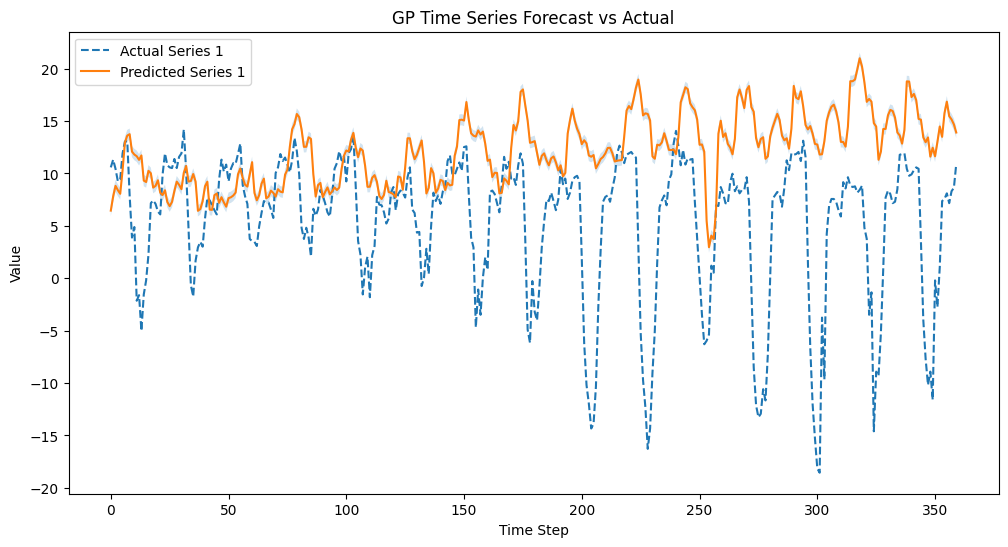

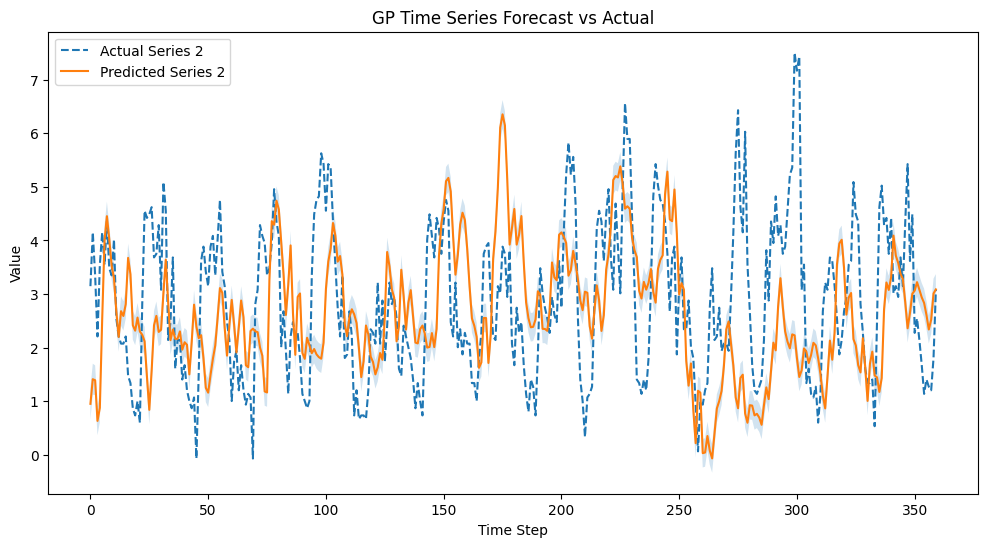

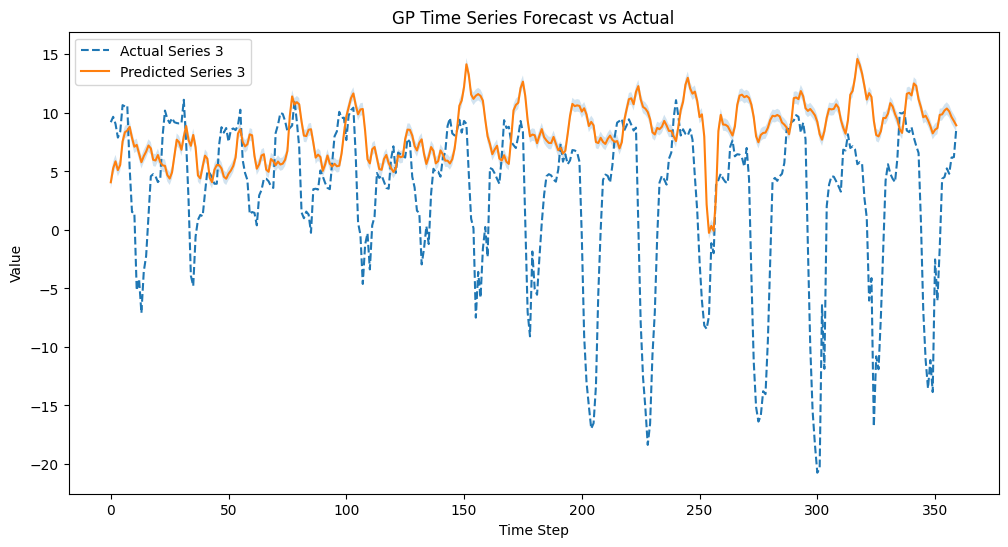

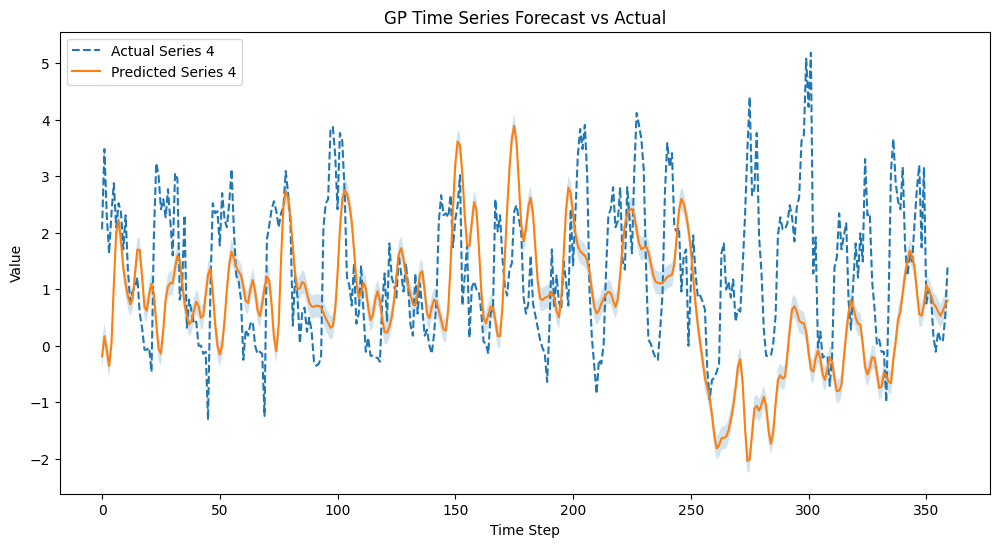

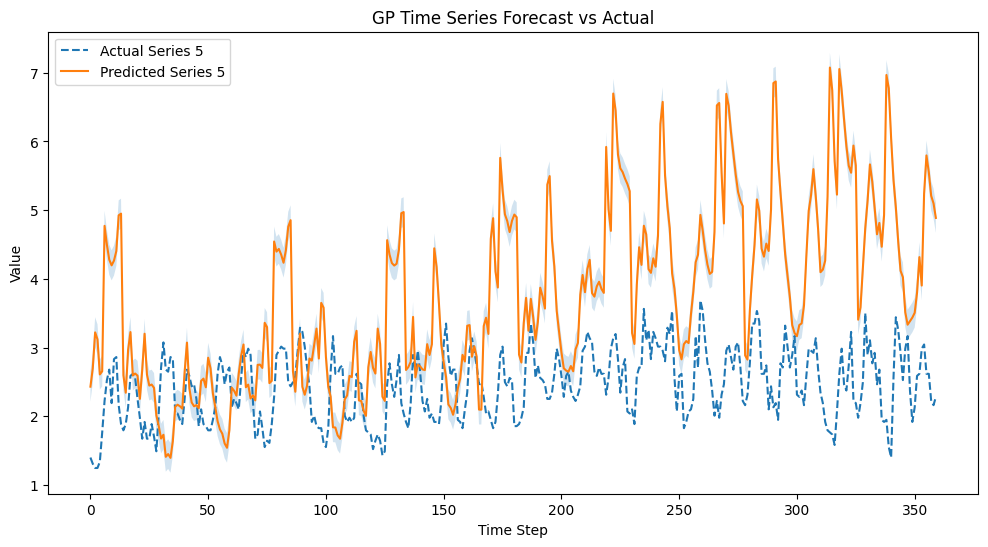

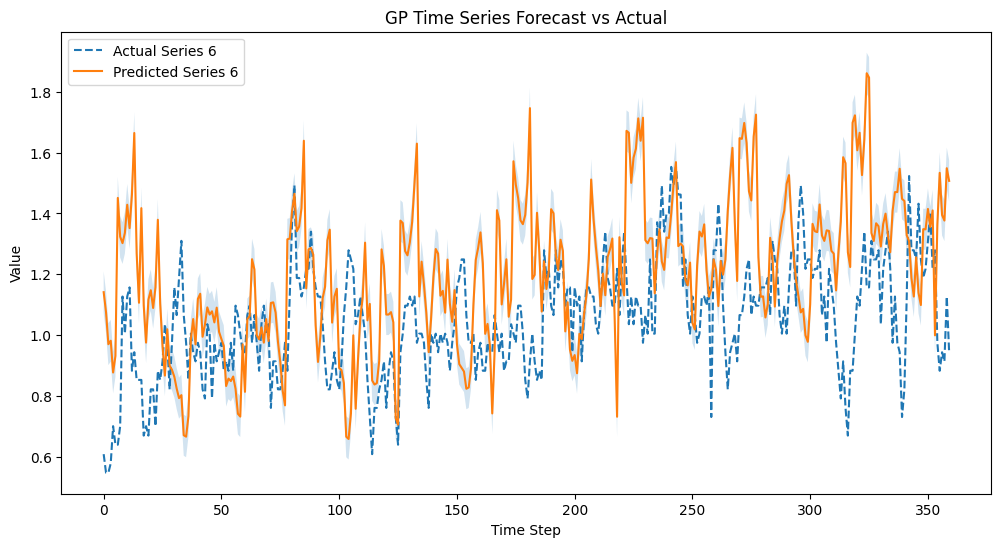

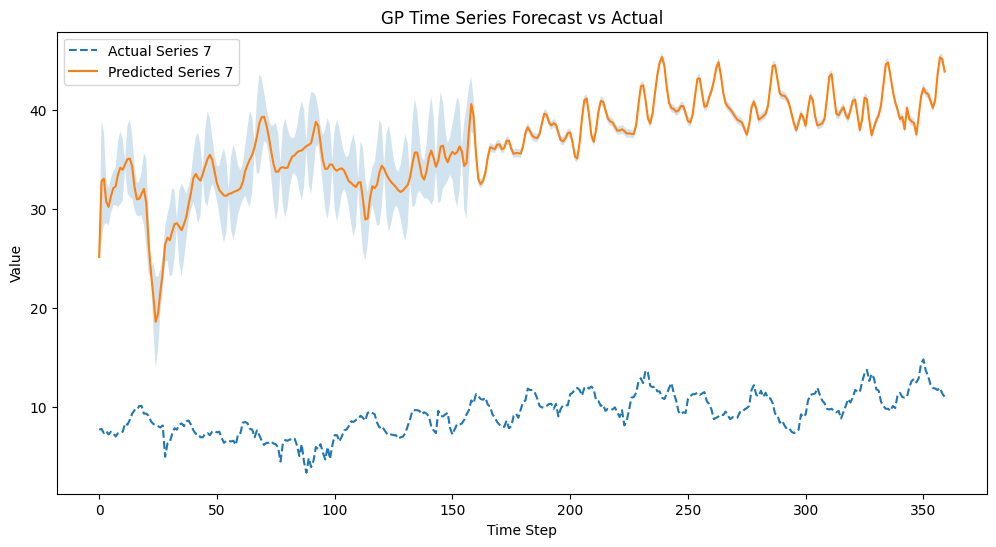

In [17]:
import matplotlib.pyplot as plt

# Ensure data is on CPU
test_x_cpu = test_x.cpu()
test_y_cpu = test_y.cpu()
mean_cpu = mean.cpu()
lower_cpu = lower.cpu()
upper_cpu = upper.cpu()

# Plot each series independently
for i in range(num_series):
    plt.figure(figsize=(12, 6))
    plt.plot(test_x_cpu, test_y_cpu[:, i], label=f"Actual Series {i+1}", linestyle="dashed")
    plt.plot(test_x_cpu, mean_cpu[:, i], label=f"Predicted Series {i+1}")
    plt.fill_between(test_x_cpu, lower_cpu[:, i], upper_cpu[:, i], alpha=0.2)
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title("GP Time Series Forecast vs Actual")
    plt.legend()
    plt.show()

## fit on the first 100 batches

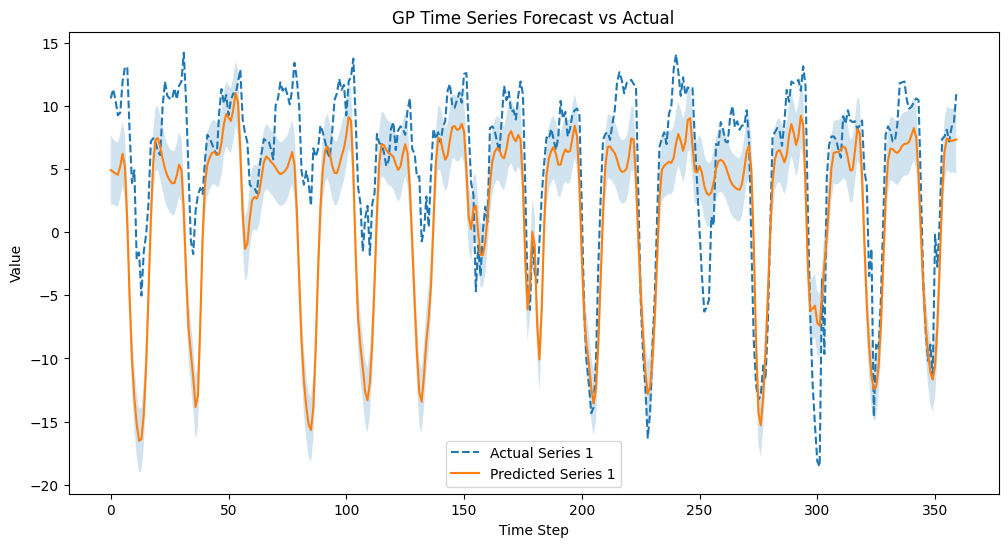

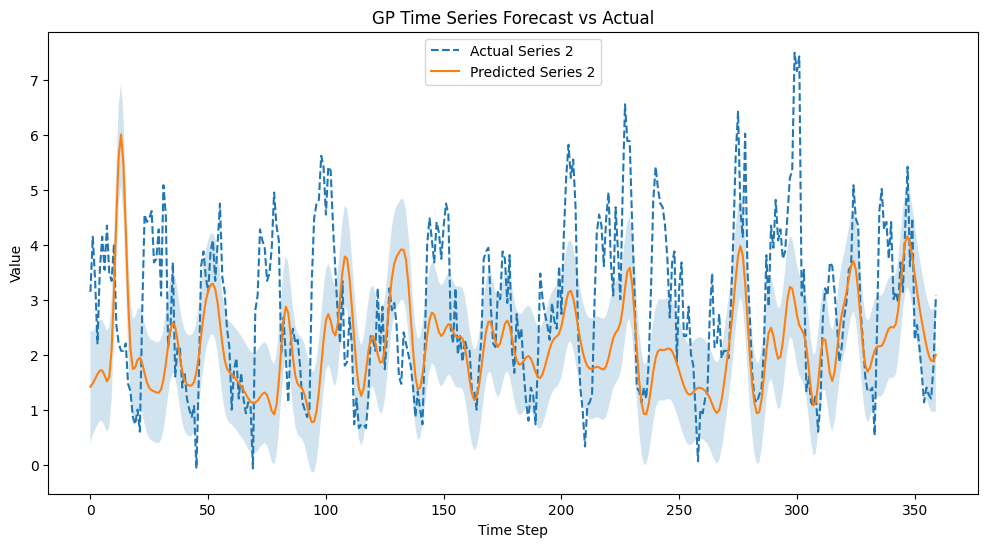

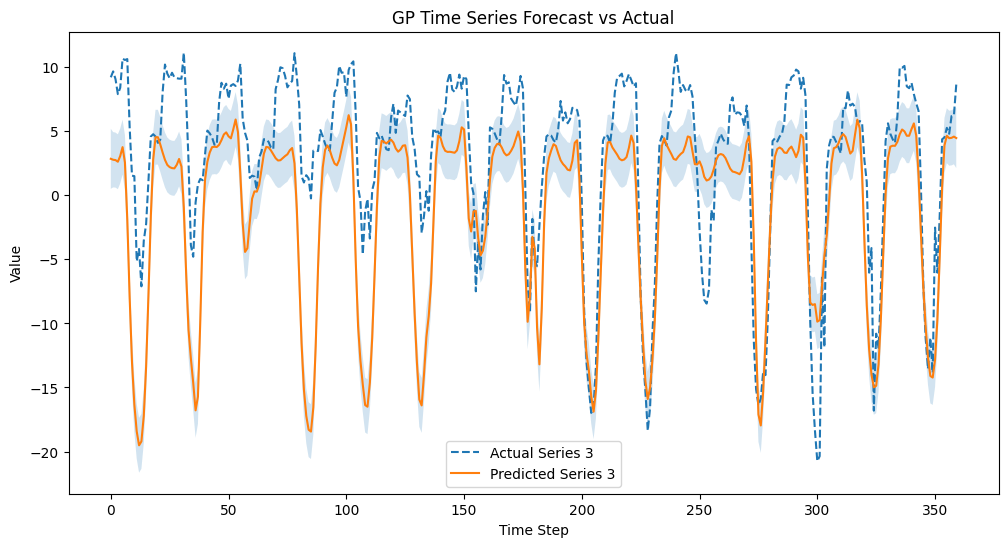

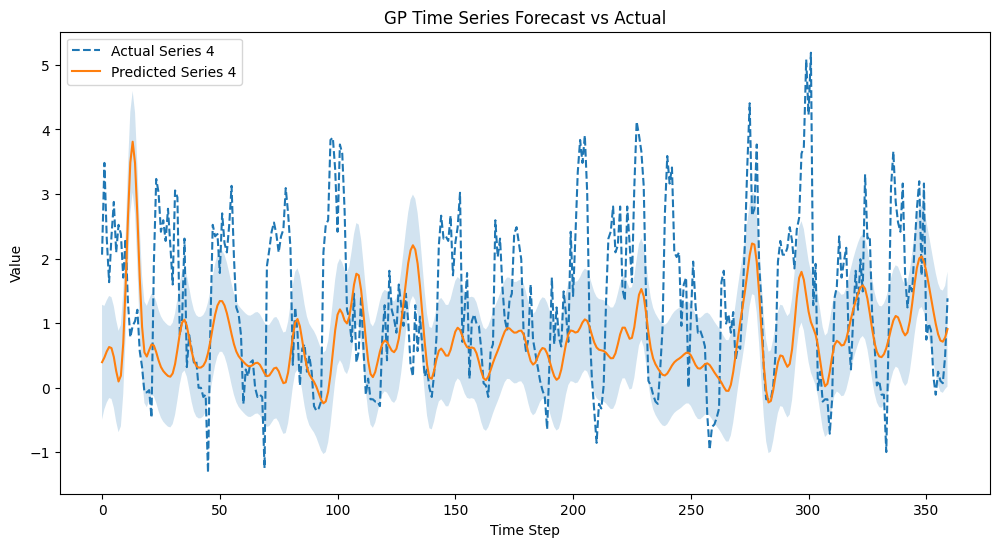

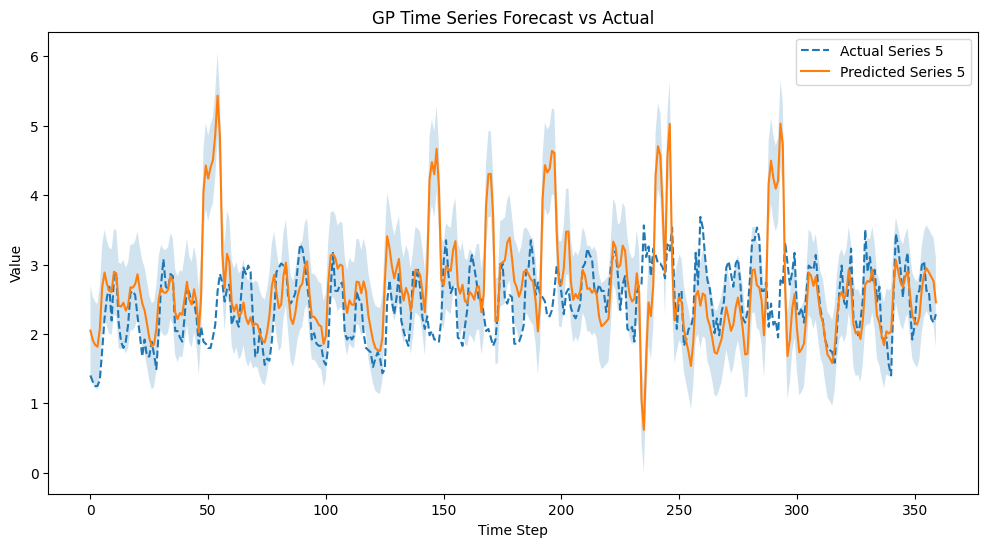

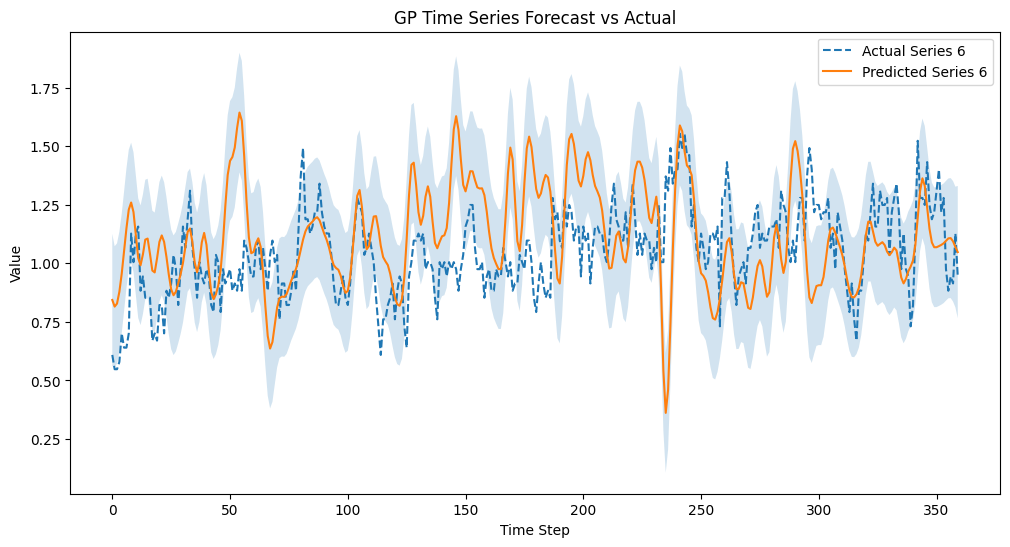

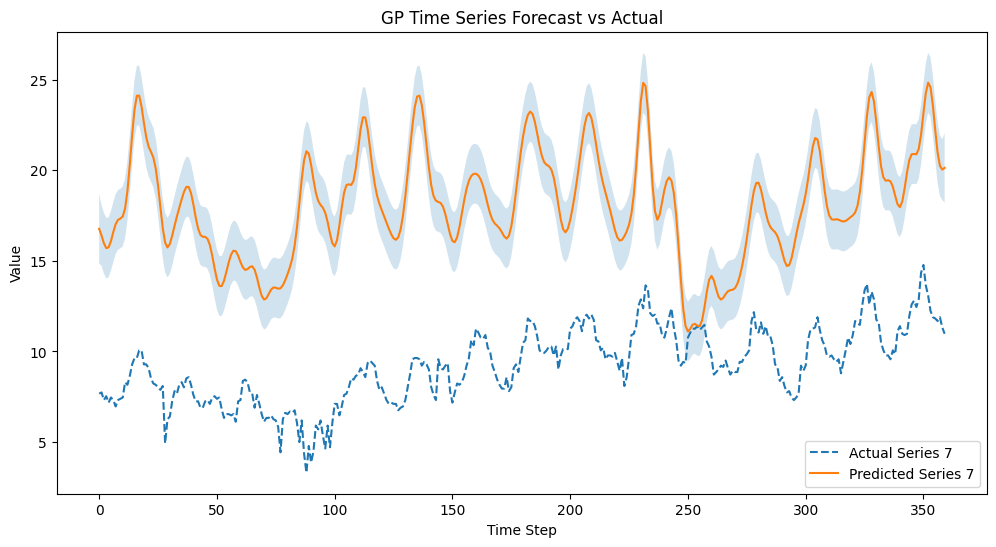

In [14]:
import matplotlib.pyplot as plt

# Ensure data is on CPU
test_x_cpu = test_x.cpu()
test_y_cpu = test_y.cpu()
mean_cpu = mean.cpu()
lower_cpu = lower.cpu()
upper_cpu = upper.cpu()

# Plot each series independently
for i in range(num_series):
    plt.figure(figsize=(12, 6))
    plt.plot(test_x_cpu, test_y_cpu[:, i], label=f"Actual Series {i+1}", linestyle="dashed")
    plt.plot(test_x_cpu, mean_cpu[:, i], label=f"Predicted Series {i+1}")
    plt.fill_between(test_x_cpu, lower_cpu[:, i], upper_cpu[:, i], alpha=0.2)
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title("GP Time Series Forecast vs Actual")
    plt.legend()
    plt.show()

In [ ]:
def predict_gp(gp_model, likelihood, future_steps=50):
    gp_model.eval()
    likelihood.eval()

    # Generate future time steps (assuming equally spaced time points)
    last_time_step = gp_model.train_inputs[0].max().item()
    test_x = torch.arange(last_time_step + 1, last_time_step + 1 + future_steps, dtype=torch.float32)

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_dist = likelihood(gp_model(test_x.to(device)))

    return test_x, pred_dist

for batch_idx, batch in enumerate(train_loader):
    if batch_idx >= 1:
        break
    past_target = batch['past_target_cdf'].to(device)
    past_target = past_target[0, :, 0]  # Use first time series & first window
    batch_size = 1

    train_length = past_target.shape[0]
    train_x = torch.arange(train_length, dtype=torch.float32, device=device).repeat(batch_size, 1).flatten().unsqueeze(1).to(device)
    train_y = past_target.flatten().to(device)

    future_target = batch['future_target_cdf'].to(device)
    future_target = future_target[0, :, 0]  # Use first time series & first window

    val_length = future_target.shape[0]
    print(val_length)
    val_x = torch.arange(train_length, train_length + val_length,  dtype=torch.float32, device=device).repeat(batch_size, 1).flatten().unsqueeze(1).to(device)
    val_y = future_target.flatten().to(device)
    print(val_x.shape)
    print(val_y.shape)


    gp_model.eval()
    likelihood.eval()

    horizon = torch.cat([train_x, val_x]).flatten()
    print(horizon.shape)

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_dist = likelihood(gp_model(horizon.to(device)))

    # Predict next 50 time steps
    #val_x, pred_dist = predict_gp(gp_model, likelihood)
    
    # Get mean and confidence intervals
    pred_mean = pred_dist.mean
    pred_lower, pred_upper = pred_dist.confidence_region()
    
    # Plot the results
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k.', label="Train Data")
    plt.plot(val_x.cpu().numpy(), val_y.cpu().numpy(), 'k.', label="Val Data")
    plt.plot(horizon.cpu().numpy(), pred_mean.cpu().numpy(), 'b', label="Prediction Mean")
    plt.fill_between(horizon.flatten().cpu().numpy(), pred_lower.cpu().numpy(), pred_upper.cpu().numpy(), alpha=0.3, label="Confidence Interval")
    plt.legend()
    plt.show()

# Predict using the trained Batch GP
def predict(model, likelihood, test_x):
    model.eval()
    likelihood.eval()
    test_x = test_x.to(device)  # Move test data to GPU
    with torch.no_grad():
        pred = likelihood(model(test_x))
    return pred.to("cpu")  # Move prediction back to CPU for further processing

# Example: Predict for all 7 time series
test_x = torch.linspace(0, 10, 50).unsqueeze(-1).to(device)  # 50 test points
predictions = predict(model, likelihood, test_x)

In [ ]:
# Predict using the trained Batch GP
def predict(model, likelihood, test_x):
    model.eval()
    likelihood.eval()
    test_x = test_x.to(device)  # Move test data to GPU
    
    with torch.no_grad():
        pred = likelihood(model(test_x))
    
    return pred.to("cpu")  # Move prediction back to CPU for further processing

# Example: Predict for all 7 time series
test_x = torch.linspace(0, 10, 50).unsqueeze(-1).to(device)  # 50 test points
predictions = predict(model, likelihood, test_x)




# Training Setup
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=7).to(device)
model = MultiTaskGPModel(None, None, likelihood).to(device)  # We'll update train data dynamically
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Training loop with batches
num_epochs = 5
for epoch in range(num_epochs):
    for batch in train_loader:  # Assume dataloader yields (batch_size, horizon_length, 7)
        past_target = batch['past_target_cdf'].to(device)
        future_target = batch['future_target_cdf'].to(device)
        targets = torch.cat([past_target, future_target], dim=1)  # (32, 360, 7)
        batch_size, horizon_length, num_series = targets.shape
        
        # Create time indices (assuming uniform spacing)
        time_indices = torch.arange(horizon_length).repeat(batch_size, 1).reshape(-1, 1).to(device)
        
        # Flatten batch to match GP input format
        train_x = time_indices.repeat(7, 1).to(device)  # Repeat for each time series
        train_y = targets.permute(2, 0, 1).reshape(-1, 1).to(device)  # Move num_series first, then flatten
        
        # Correct task indices (repeat per time step, not entire batch)
        task_indices = torch.arange(7).repeat_interleave(horizon_length * batch_size).to(device)
        train_inputs = (train_x, task_indices)
        model.set_train_data(train_inputs, train_y, strict=False)
        
        # Forward pass using the exact same format
        model.train()
        likelihood.train()
        
        # Zero gradients
        optimizer.zero_grad()

        # Compute loss
        output = model(*train_inputs)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 24.23 GiB. GPU 0 has a total capacity of 10.75 GiB of which 10.55 GiB is free. Including non-PyTorch memory, this process has 198.00 MiB memory in use. Of the allocated memory 6.56 MiB is allocated by PyTorch, and 1.44 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# SKlearn

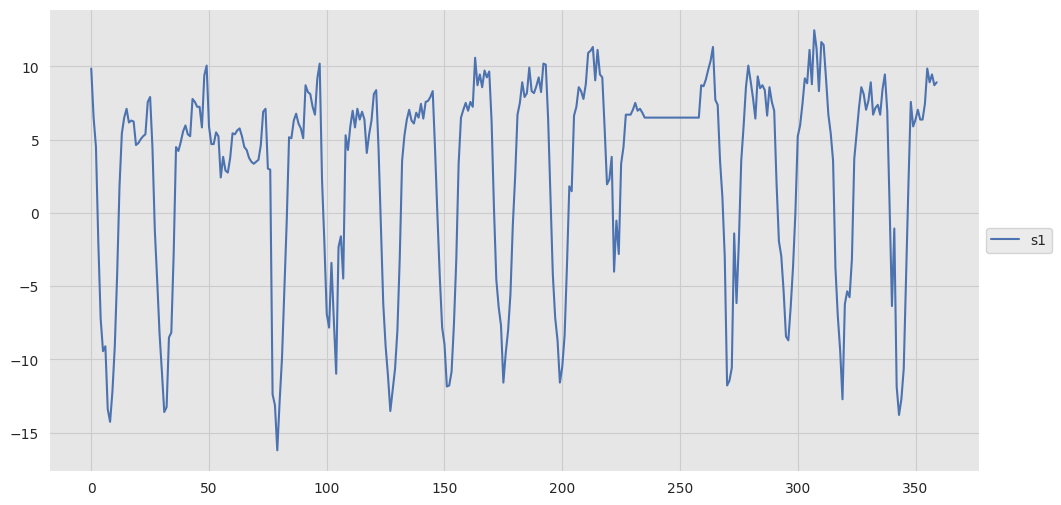

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

#batch = next(iter(train_loader))

train_iter = iter(train_loader)  # Create an iterator
first_batch = next(train_iter)   # Get the first batch
# Example shapes from DataLoader
past_target = batch['past_target_cdf'].to(device)
future_target = batch['future_target_cdf'].to(device)
targets = torch.cat([past_target, future_target], dim=1)  # (32, 360, 7)
batch_size, horizon_length, num_series = targets.shape
horizon = np.arange(horizon_length)

train_x = horizon[:(360-96)]
test_x = horizon[(360-96):]
train_y = np.array(targets[0, :(360-96), 0].to('cpu'))
test_y = np.array(targets[0, (360-96):, 0].to('cpu'))

fig, ax = plt.subplots()
sns.lineplot(x=np.concatenate([train_x, test_x]), y=np.concatenate([train_y, test_y]), color=sns_c[0], label='s1', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [67]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, ConstantKernel, RationalQuadratic, DotProduct

kernel = (
    WhiteKernel(noise_level=0.1**2, noise_level_bounds=(0.01**2, 0.2**2)) + 
    ConstantKernel(5, constant_value_bounds=(1, 10)) * 
    ExpSineSquared(length_scale=20.0, periodicity=40, periodicity_bounds=(30, 50)) +
    ConstantKernel(1.0) * RationalQuadratic(length_scale=10, alpha=1.5) + 
    ConstantKernel(1.0) * DotProduct(sigma_0=1.0)
)

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, normalize_y=True, alpha=1e-5)



gp1_prior_samples = gp1.sample_y(X=train_x.reshape(-1, 1), n_samples=100)
gp1.fit(train_x.reshape(-1, 1), train_y)

GaussianProcessRegressor(alpha=1e-05,
                         kernel=WhiteKernel(noise_level=0.01) + 2.24**2 * ExpSineSquared(length_scale=10, periodicity=40) + 1**2 * RationalQuadratic(alpha=1.5, length_scale=10),
                         n_restarts_optimizer=20, normalize_y=True)

[Text(0.5, 1.0, 'Prediction Sample 1'), Text(0.5, 0, 't'), Text(0, 0.5, '')]

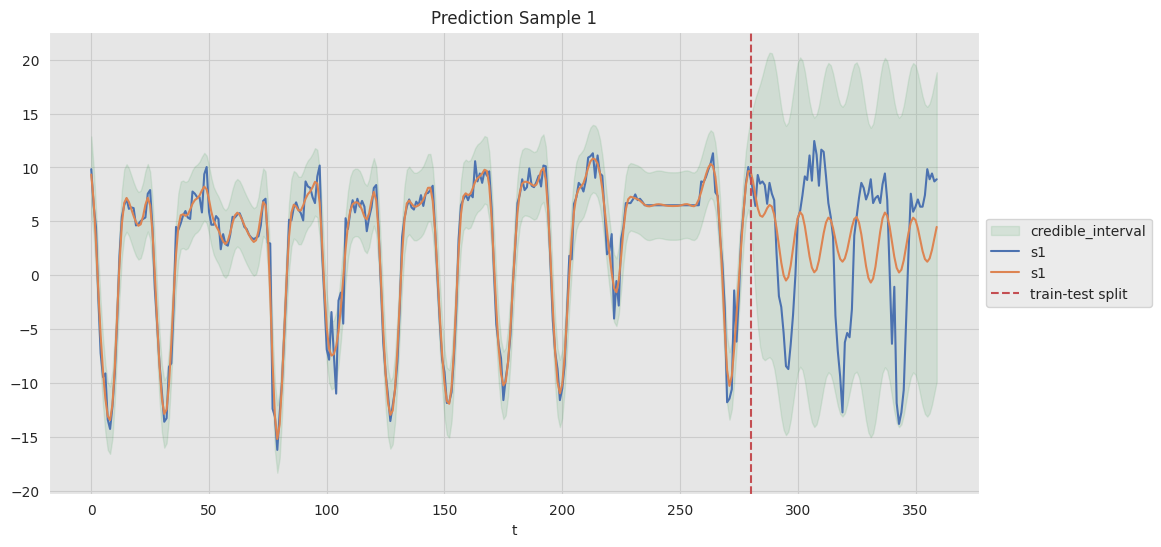

In [55]:
# Generate predictions.
y_pred, y_std = gp1.predict(np.concatenate([train_x, test_x]).reshape(-1, 1), return_std=True)

fig, ax = plt.subplots()

ax.fill_between(
    x=np.concatenate([train_x, test_x]), 
    y1=y_pred - 2*y_std, 
    y2=y_pred + 2*y_std, 
    color=sns_c[2], 
    alpha=0.15, 
    label='credible_interval'
)

#sns.lineplot(x='t', y='y1', data=data_df, color=sns_c[0], label = 'y1', ax=ax)
#sns.lineplot(x='t', y='y_pred', data=data_df, color=sns_c[2], label='y_pred', ax=ax)
sns.lineplot(x=np.concatenate([train_x, test_x]), y=np.concatenate([train_y, test_y]), color=sns_c[0], label='s1', ax=ax) 
sns.lineplot(x=np.concatenate([train_x, test_x]), y=y_pred, color=sns_c[1], label='s1', ax=ax) 

ax.axvline(280, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Prediction Sample 1', xlabel='t', ylabel='')

torch.Size([32, 96, 7])


[Text(0.5, 1.0, 'Prediction Sample 1'), Text(0.5, 0, 't'), Text(0, 0.5, '')]

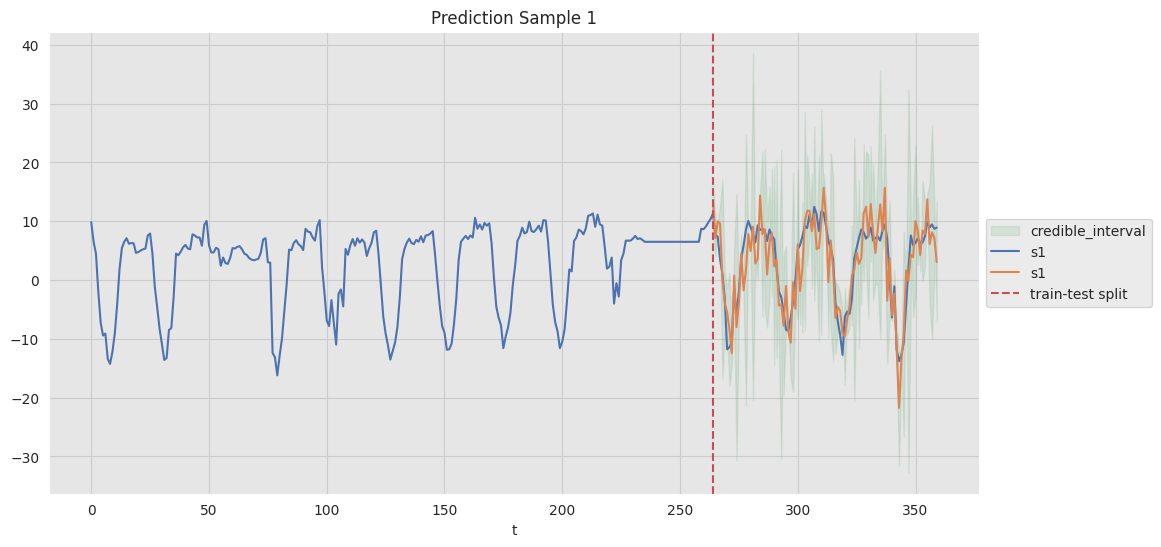

In [94]:
batch_data = ProbTSBatchData(first_batch, device)
forecasts = cli.model.forecaster.forecast(batch_data, None)
print(forecasts[0].shape)
window, series = 0, 0
np.random.seed(42)
mean = np.array(test_y+ np.random.normal(loc=0, scale=4, size=96))  # Mean 0, Std 1)#np.array(forecasts[0][window, :, series].to('cpu').detach().numpy())
std = np.random.normal(loc=0, scale=6, size=96) #np.array(forecasts[1][window, :, series].to('cpu').detach().numpy())

fig, ax = plt.subplots()

ax.fill_between(
    x=test_x, 
    y1=mean - 2*std, 
    y2=mean + 2*std, 
    color=sns_c[2], 
    alpha=0.15, 
    label='credible_interval'
)

#sns.lineplot(x='t', y='y1', data=data_df, color=sns_c[0], label = 'y1', ax=ax)
#sns.lineplot(x='t', y='y_pred', data=data_df, color=sns_c[2], label='y_pred', ax=ax)
sns.lineplot(x=np.concatenate([train_x, test_x]), y=np.concatenate([train_y, test_y]), color=sns_c[0], label='s1', ax=ax) 
sns.lineplot(x=test_x, y=mean, color=sns_c[1], label='s1', ax=ax) 

ax.axvline(360-96, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Prediction Sample 1', xlabel='t', ylabel='')

In [95]:
# two options to include the prob forecasts
# 1. use them as prior -> need predictions for whole horizon and then fit GP
# 2. update GP predictions using the prob model -> y_cov_combined = y_cov_gp + np.diag(y_std_other**2) 
#    -> how to incorporate the mean (via lambda or other way?)

# Both methods are not necessarily what i want, 
# I want a trained GP that generates realistic samples based off the prob predictions 
#     -> maybe 2.) is closest to what i need

[Text(0.5, 1.0, 'Prediction Sample 1'), Text(0.5, 0, 't'), Text(0, 0.5, '')]

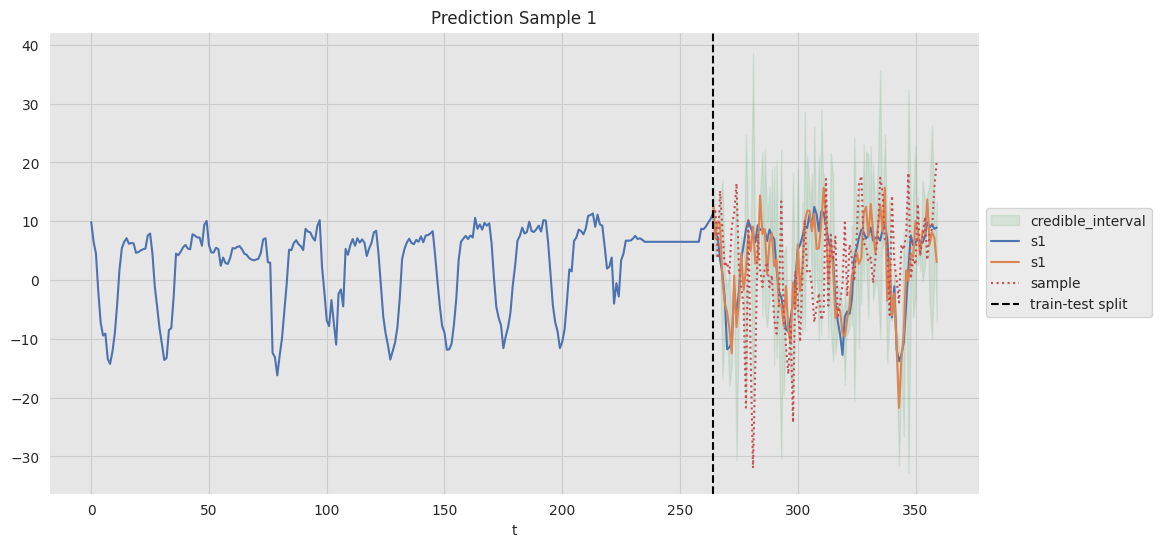

In [118]:
# Compute the GP prior covariance
y_mean_gp, y_cov_gp = gp1.predict(test_x.reshape(-1, 1), return_cov=True)

# Modify covariance to include external uncertainty
y_cov_combined = y_cov_gp.copy()
np.fill_diagonal(y_cov_combined, np.diag(std**2).diagonal())  
#y_cov_combined= y_cov_gp + np.diag(std**2)  # Add variances from external model

# Generate correlated samples using the new covariance
n_samples = 100
gp_samples = np.random.multivariate_normal(mean=y_mean_gp, cov=y_cov_combined, size=n_samples)

fig, ax = plt.subplots()

ax.fill_between(
    x=test_x, 
    y1=mean - 2*std, 
    y2=mean + 2*std, 
    color=sns_c[2], 
    alpha=0.15, 
    label='credible_interval'
)

#sns.lineplot(x='t', y='y1', data=data_df, color=sns_c[0], label = 'y1', ax=ax)
#sns.lineplot(x='t', y='y_pred', data=data_df, color=sns_c[2], label='y_pred', ax=ax)
sns.lineplot(x=np.concatenate([train_x, test_x]), y=np.concatenate([train_y, test_y]), color=sns_c[0], label='s1', ax=ax) 
sns.lineplot(x=test_x, y=mean, color=sns_c[1], label='s1', ax=ax) 
# Plot sampled trajectories from GP

for i in range(1):
    sns.lineplot(x=test_x, y=gp_samples[i, :], alpha=1, linestyle=':', color=sns_c[i+3], label='sample', ax=ax)  # Transparent lines


ax.axvline(360-96, color='black', linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Prediction Sample 1', xlabel='t', ylabel='')

# GPR1

In [ ]:
import torch
import gpytorch

class IndependentMultiOutputGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihoods):
        """
        GP model that handles multiple independent time series (no correlation between them).
        
        train_x: Shape [batch_size, horizon, 1]
        train_y: Shape [batch_size, horizon, num_channels]
        likelihoods: LikelihoodList with a separate likelihood for each time series
        """
        super().__init__(train_x, train_y, likelihoods)

        self.num_channels = train_y.shape[-1]  # 7 time series
        self.mean_modules = torch.nn.ModuleList([gpytorch.means.ConstantMean() for _ in range(self.num_channels)])
        self.covar_modules = torch.nn.ModuleList([
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) for _ in range(self.num_channels)
        ])

    def forward(self, x):
        """
        x: Shape [batch_size, horizon, 1]
        Output: List of MultivariateNormal distributions, one per time series
        """
        batch_size, horizon, _ = x.shape
        x = x.view(-1, 1)  # Flatten batch & time dimensions

        outputs = []
        for i in range(self.num_channels):
            mean_x = self.mean_modules[i](x)
            covar_x = self.covar_modules[i](x)
            outputs.append(gpytorch.distributions.MultivariateNormal(mean_x, covar_x))

        return outputs

# Training function
def train_gp(model, likelihoods, train_x, train_y, training_iter=100):
    model.train()
    likelihoods.train()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.SumMarginalLogLikelihood(likelihoods, model)

    for i in range(training_iter):
        optimizer.zero_grad()
        outputs = model(train_x)  # List of MultivariateNormals
        loss = -sum(mll(outputs[i], train_y[..., i].view(-1)) for i in range(num_channels))  # Flattened loss per GP
        loss.backward()
        optimizer.step()

    return model, likelihoods

batch = next(iter(train_loader))
# Example shapes from DataLoader
past_target = batch['past_target_cdf'].to(device)
future_target = batch['future_target_cdf'].to(device)
targets = torch.cat([past_target, future_target], dim=1)  # (32, 360, 7)
batch_size, horizon_length, num_series = targets.shape

# Define separate likelihoods
likelihoods = gpytorch.likelihoods.LikelihoodList(
    *[gpytorch.likelihoods.GaussianLikelihood() for _ in range(num_channels)]
)

# Instantiate the model
model = IndependentMultiOutputGP(train_x, train_y, likelihoods)

# Train the unified model
model, likelihoods = train_gp(model, likelihoods, train_x, train_y)

# Predictions (same batch size for efficiency)
model.eval()
likelihoods.eval()

test_x = torch.randn(batch_size, horizon, 1)  # Example test input
predictions = [likelihoods.likelihoods[i](model(test_x)[i]) for i in range(num_channels)]


In [23]:
import torch
import gpytorch

class MultiTaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        ) * gpytorch.kernels.IndexKernel(num_tasks=7, rank=2)

    def forward(self, x, task_indices):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x, task_indices)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

train_loader = cli.datamodule.train_dataloader()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training Setup
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=7).to(device)
model = MultiTaskGPModel(None, None, likelihood).to(device)  # We'll update train data dynamically
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Training loop with batches
num_epochs = 5
for epoch in range(num_epochs):
    for batch in train_loader:  # Assume dataloader yields (batch_size, horizon_length, 7)
        past_target = batch['past_target_cdf'].to(device)
        future_target = batch['future_target_cdf'].to(device)
        targets = torch.cat([past_target, future_target], dim=1)  # (32, 360, 7)
        batch_size, horizon_length, num_series = targets.shape
        
        # Create time indices (assuming uniform spacing)
        time_indices = torch.arange(horizon_length).repeat(batch_size, 1).reshape(-1, 1).to(device)
        
        # Flatten batch to match GP input format
        train_x = time_indices.repeat(7, 1).to(device)  # Repeat for each time series
        train_y = targets.permute(2, 0, 1).reshape(-1, 1).to(device)  # Move num_series first, then flatten
        
        # Correct task indices (repeat per time step, not entire batch)
        task_indices = torch.arange(7).repeat_interleave(horizon_length * batch_size).to(device)
        train_inputs = (train_x, task_indices)
        model.set_train_data(train_inputs, train_y, strict=False)
        
        # Forward pass using the exact same format
        model.train()
        likelihood.train()
        
        # Zero gradients
        optimizer.zero_grad()

        # Compute loss
        output = model(*train_inputs)  # ✅ Correct: Unpack as separate arguments
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")


OutOfMemoryError: CUDA out of memory. Tried to allocate 24.23 GiB. GPU 0 has a total capacity of 47.53 GiB of which 22.95 GiB is free. Including non-PyTorch memory, this process has 24.57 GiB memory in use. Of the allocated memory 24.25 GiB is allocated by PyTorch, and 15.31 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# GPR

In [ ]:
import torch
import gpytorch
from tqdm import tqdm

train_loader = cli.datamodule.train_dataloader()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BatchIndependentMultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        batch_size = train_x.shape[0]  # 32
        num_tasks = train_y.shape[-1]  # 7 (num_series)
        
        batch_shape = torch.Size([batch_size])  # Only batch dimension

        # Use MultitaskMean instead of ConstantMean
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_tasks
        )

        # Use MultitaskKernel instead of simple RBFKernel
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(batch_shape=batch_shape),
            num_tasks=num_tasks,
            rank=1  # Adjust if needed
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

def train_minimal_gp(train_loader, num_iterations=50):
    print("Training GP on full dataset across iterations...")

    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=7).to(device)

    first_batch = next(iter(train_loader))
    past_target = first_batch['past_target_cdf'].to(device)
    future_target = first_batch['future_target_cdf'].to(device)
    targets = torch.cat([past_target, future_target], dim=1)  # (batch_size, time_steps, num_series)

    # Fix `train_x` dimensions
    time_steps = targets.shape[1]  # 360
    num_series = targets.shape[2]  # 7
    batch_size = targets.shape[0]  # 32

    train_x = torch.arange(time_steps, dtype=torch.float32, device=device)  # (time_steps,)
    train_x = train_x.unsqueeze(0).unsqueeze(-1)  # (1, time_steps, 1)
    train_x = train_x.expand(batch_size, time_steps, 1)  # (batch_size, time_steps, 1)

    print(f'x shape: {train_x.shape}')  # Expected: (32, 360, 1)
    print(f'y shape: {targets.shape}')  # Expected: (32, 360, 7)

    # Initialize GP model
    gp_model = BatchIndependentMultitaskGPModel(train_x, targets, likelihood).to(device)
    optimizer = torch.optim.Adam(gp_model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)

    progress_bar = tqdm(range(num_iterations), total=num_iterations)

    for _ in progress_bar:  # Iterate over training steps
        for batch_idx, batch in enumerate(train_loader):  # Iterate over batches per step
            if batch_idx >= 100:
                break

            past_target = batch['past_target_cdf'].to(device)
            future_target = batch['future_target_cdf'].to(device)
            targets = torch.cat([past_target, future_target], dim=1)  # (32, 360, 7)

            gp_model.train()
            likelihood.train()
            optimizer.zero_grad()

            output = gp_model(train_x)  # Forward pass
            loss = -mll(output, targets)  # Compute loss

            progress_bar.set_description(f"Batch {batch_idx} - Loss: {loss:.4f}")
            loss.backward()
            optimizer.step()

    return gp_model, likelihood

# Train the GP
gp_model, likelihood = train_minimal_gp(train_loader)

Training GP on full dataset across iterations...
x shape: torch.Size([32, 360, 1])
y shape: torch.Size([32, 360, 7])


  0%|                                                                                             | 0/50 [00:01<?, ?it/s]


In [ ]:
def predict_gp(gp_model, likelihood, future_steps=50):
    gp_model.eval()
    likelihood.eval()

    # Generate future time steps (assuming equally spaced time points)
    last_time_step = gp_model.train_inputs[0].max().item()
    test_x = torch.arange(last_time_step + 1, last_time_step + 1 + future_steps, dtype=torch.float32)

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_dist = likelihood(gp_model(test_x.to(device)))

    return test_x, pred_dist

for batch_idx, batch in enumerate(train_loader):
    if batch_idx >= 1:
        break
    past_target = batch['past_target_cdf'].to(device)
    past_target = past_target[0, :, 0]  # Use first time series & first window
    batch_size = 1

    train_length = past_target.shape[0]
    train_x = torch.arange(train_length, dtype=torch.float32, device=device).repeat(batch_size, 1).flatten().unsqueeze(1).to(device)
    train_y = past_target.flatten().to(device)

    future_target = batch['future_target_cdf'].to(device)
    future_target = future_target[0, :, 0]  # Use first time series & first window

    val_length = future_target.shape[0]
    print(val_length)
    val_x = torch.arange(train_length, train_length + val_length,  dtype=torch.float32, device=device).repeat(batch_size, 1).flatten().unsqueeze(1).to(device)
    val_y = future_target.flatten().to(device)
    print(val_x.shape)
    print(val_y.shape)


    gp_model.eval()
    likelihood.eval()

    horizon = torch.cat([train_x, val_x]).flatten()
    print(horizon.shape)

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_dist = likelihood(gp_model(horizon.to(device)))

    # Predict next 50 time steps
    #val_x, pred_dist = predict_gp(gp_model, likelihood)
    
    # Get mean and confidence intervals
    pred_mean = pred_dist.mean
    pred_lower, pred_upper = pred_dist.confidence_region()
    
    # Plot the results
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k.', label="Train Data")
    plt.plot(val_x.cpu().numpy(), val_y.cpu().numpy(), 'k.', label="Val Data")
    plt.plot(horizon.cpu().numpy(), pred_mean.cpu().numpy(), 'b', label="Prediction Mean")
    plt.fill_between(horizon.flatten().cpu().numpy(), pred_lower.cpu().numpy(), pred_upper.cpu().numpy(), alpha=0.3, label="Confidence Interval")
    plt.legend()
    plt.show()


# old

In [3]:
train_loader = cli.datamodule.train_dataloader()

class GlobalGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_y, likelihood):
        batch_size, train_length, num_series = train_y.shape

        # Automatically generate time indices for each window
        train_t = torch.arange(train_length, dtype=torch.float32).repeat(batch_size, 1)  # Shape: (batch_size, train_length)

        # Create series indices (which time series each point belongs to)
        train_series_idx = torch.arange(num_series, dtype=torch.float32).repeat(batch_size, train_length, 1)  # Shape: (batch_size, train_length, num_series)

        # Expand to match train_y shape and flatten
        train_x = torch.stack([train_t.unsqueeze(-1).expand(-1, -1, num_series), train_series_idx], dim=-1)  # Shape: (batch_size, train_length, num_series, 2)
        train_x = train_x.reshape(batch_size * train_length * num_series, 2)  # Flatten

        # Flatten targets to match shape
        train_y = train_y.flatten()

        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        # Use an RBF kernel + Multi-Task Kernel for shared learning
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=num_series, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)



In [13]:
print(dir(train_loader))
print(dir(cli))
print(train_loader.batch_size)

['_DataLoader__initialized', '_DataLoader__multiprocessing_context', '_IterableDataset_len_called', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_auto_collation', '_dataset_kind', '_get_iterator', '_index_sampler', '_is_protocol', '_iterator', 'batch_sampler', 'batch_size', 'check_worker_number_rationality', 'collate_fn', 'dataset', 'drop_last', 'generator', 'in_order', 'multiprocessing_context', 'num_workers', 'persistent_workers', 'pin_memory', 'pin_memory_device', 'prefetch_factor', 'sampler', 'timeout', 'worker_init_fn']
['__class__', '__delattr__', '__dict__', '__dir__', '__do

In [4]:
import torch
import gpytorch
from tqdm import tqdm
train_loader = cli.datamodule.train_dataloader()
class MinimalGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_minimal_gp(train_loader, num_iterations=50):
    print("Training minimal GP on first time series...")

    for batch_idx, batch in enumerate(train_loader):#, total=len(train_loader)):
        past_target = batch['past_target_cdf']  # Shape: (batch_size, train_length, num_series)
        past_target = past_target[:, :, 0]  # Select first time series (Shape: batch_size x train_length)

        # Assume equal time spacing (using indices as x)
        batch_size, train_length = past_target.shape
        train_x = torch.arange(train_length, dtype=torch.float32).unsqueeze(1).expand(train_length, batch_size).reshape(-1)
        train_y = past_target.flatten()  # Flatten targets

        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        gp_model = MinimalGPModel(train_x, train_y, likelihood)

        gp_model.train()
        likelihood.train()
        optimizer = torch.optim.Adam(gp_model.parameters(), lr=0.1)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)

        for _ in tqdm(range(num_iterations), total=num_iterations):  # Reduce iterations for efficiency
            optimizer.zero_grad()
            output = gp_model(train_x)
            loss = -mll(output, train_y)
            loss.backward()
            optimizer.step()

        return gp_model, likelihood  # Train only on the first batch and return

# Train the minimal GP
gp_model, likelihood = train_minimal_gp(train_loader)

Training minimal GP on first time series...


100%|████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:16<00:00,  1.54s/it]


In [29]:
import torch
import gpytorch
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = cli.datamodule.train_dataloader()
class MinimalGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def get_data(batch, window=0):
    past_target = batch['past_target_cdf'].to(device)
    past_target = past_target[window, :, 0]  # Use first time series & first window
    batch_size = 1

    train_length = past_target.shape[0]
    train_x = torch.arange(train_length, dtype=torch.float32, device=device).repeat(batch_size, 1).flatten().unsqueeze(1).to(device)
    train_y = past_target.flatten().to(device)

    future_target = batch['future_target_cdf'].to(device)
    future_target = future_target[window, :, 0]  # Use first time series & first window

    val_length = future_target.shape[0]
    val_x = torch.arange(train_length, train_length + val_length,  dtype=torch.float32, device=device).repeat(batch_size, 1).flatten().unsqueeze(1).to(device)
    val_y = future_target.flatten().to(device)
    horizon = torch.cat([train_x, val_x]).flatten()
    return horizon
    
    

def train_minimal_gp(train_loader, num_iterations=50):
    print("Training GP on full dataset across iterations...")

    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

    first_batch = next(iter(train_loader))
    horizon = get_data(first_batch)
    batch_size = first_batch['past_target_cdf'][:, :, 0].shape[0]

    y = torch.cat([first_batch['past_target_cdf'][0, :, 0], first_batch['future_target_cdf'][0, :, 0]])

    # Initialize GP model once
    gp_model = MinimalGPModel(horizon, y, likelihood).to(device)

    optimizer = torch.optim.Adam(gp_model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)

    progress_bar = tqdm(range(num_iterations), total=num_iterations)

    for _ in progress_bar:  # Iterate over training steps
        for batch_idx, batch in enumerate(train_loader):  # Iterate over batches per step
            if batch_idx >= 100:
                break
            
            past_target = batch['past_target_cdf'].to(device)
            future_target = batch['future_target_cdf'].to(device)
            targets = torch.cat([past_target, future_target], dim=1)
            for window in range(batch_size):
                target = targets[window, :, 0]
                gp_model.train()
                likelihood.train()
                optimizer.zero_grad()
                output = gp_model(horizon)
                loss = -mll(output, target)
                progress_bar.set_description(f"Batch {batch_idx} - Window {window}- Current Loss: {loss:.4f}.")
                loss.backward()
                optimizer.step()
    return gp_model, likelihood

# Train the GP using batches (pre-windowed)
gp_model, likelihood = train_minimal_gp(train_loader)

Training GP on full dataset across iterations...


Batch 99 - Window 31- Current Loss: 2.6468.: 100%|███████████████████████████████████████| 50/50 [08:55<00:00, 10.70s/it]


96
torch.Size([96, 1])
torch.Size([96])
torch.Size([360])


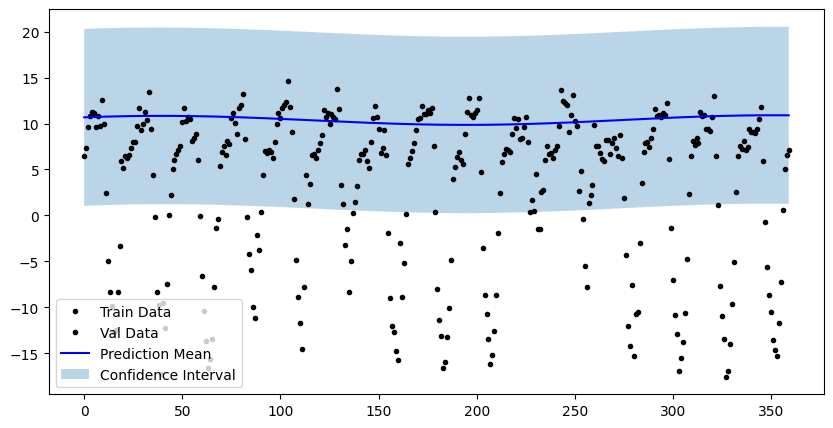

In [31]:
def predict_gp(gp_model, likelihood, future_steps=50):
    gp_model.eval()
    likelihood.eval()

    # Generate future time steps (assuming equally spaced time points)
    last_time_step = gp_model.train_inputs[0].max().item()
    test_x = torch.arange(last_time_step + 1, last_time_step + 1 + future_steps, dtype=torch.float32)

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_dist = likelihood(gp_model(test_x.to(device)))

    return test_x, pred_dist

for batch_idx, batch in enumerate(train_loader):
    if batch_idx >= 1:
        break
    past_target = batch['past_target_cdf'].to(device)
    past_target = past_target[0, :, 0]  # Use first time series & first window
    batch_size = 1

    train_length = past_target.shape[0]
    train_x = torch.arange(train_length, dtype=torch.float32, device=device).repeat(batch_size, 1).flatten().unsqueeze(1).to(device)
    train_y = past_target.flatten().to(device)

    future_target = batch['future_target_cdf'].to(device)
    future_target = future_target[0, :, 0]  # Use first time series & first window

    val_length = future_target.shape[0]
    print(val_length)
    val_x = torch.arange(train_length, train_length + val_length,  dtype=torch.float32, device=device).repeat(batch_size, 1).flatten().unsqueeze(1).to(device)
    val_y = future_target.flatten().to(device)
    print(val_x.shape)
    print(val_y.shape)


    gp_model.eval()
    likelihood.eval()

    horizon = torch.cat([train_x, val_x]).flatten()
    print(horizon.shape)

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_dist = likelihood(gp_model(horizon.to(device)))

    # Predict next 50 time steps
    #val_x, pred_dist = predict_gp(gp_model, likelihood)
    
    # Get mean and confidence intervals
    pred_mean = pred_dist.mean
    pred_lower, pred_upper = pred_dist.confidence_region()
    
    # Plot the results
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k.', label="Train Data")
    plt.plot(val_x.cpu().numpy(), val_y.cpu().numpy(), 'k.', label="Val Data")
    plt.plot(horizon.cpu().numpy(), pred_mean.cpu().numpy(), 'b', label="Prediction Mean")
    plt.fill_between(horizon.flatten().cpu().numpy(), pred_lower.cpu().numpy(), pred_upper.cpu().numpy(), alpha=0.3, label="Confidence Interval")
    plt.legend()
    plt.show()


In [35]:
import torch
import gpytorch

# Define Heteroscedastic Likelihood
class HeteroscedasticLikelihood(gpytorch.likelihoods.Likelihood):
    def __init__(self, noise):
        super().__init__()
        self.noise = noise  # Noise for heteroscedastic modeling

    def forward(self, function_samples):
        return gpytorch.distributions.Normal(function_samples, self.noise.sqrt())

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_y, likelihood):
        # Infer the number of training points from train_y
        train_length = train_y.shape[0]
        
        # Create integer-based time indices internally
        train_x = torch.arange(train_length, dtype=torch.float32).unsqueeze(-1)  # Shape: (train_length, 1)
        
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [38]:
def train_gps(train_loader):
    num_time_series = 7
    gp_models = []
    likelihoods = []

    for ts_idx in range(num_time_series):  # One GP per time series
        print(f"Training GP for Time Series {ts_idx+1}...")

        # Collect all training windows
        all_Y_train = []

        for batch_idx, batch in enumerate(train_dataloader):
            past_target = batch['past_target_cdf']  # Shape: (batch_size, 264, 7)
            Y_train = past_target[:, :, ts_idx]  # Extract only this time series

            all_Y_train.append(Y_train.flatten())  # Shape: (batch_size * train_length,)

        # Combine all batches
        Y_train_combined = torch.cat(all_Y_train)  # Shape: (total_points,)

        # Define GP model and likelihood (time indices are inferred inside GP)
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        gp_model = ExactGPModel(Y_train_combined, likelihood)

        # Train the GP
        gp_model.train()
        likelihood.train()
        optimizer = torch.optim.Adam(gp_model.parameters(), lr=0.1)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)

        for _ in range(100):  # Training iterations
            optimizer.zero_grad()
            output = gp_model(gp_model.train_inputs[0])  # Use internally defined time indices
            loss = -mll(output, Y_train_combined)
            loss.backward()
            optimizer.step()

        # Store trained GP
        gp_models.append(gp_model)
        likelihoods.append(likelihood)
    return gp_models, likelihoods

# Train the GPs
gp_models, likelihoods = train_gps(train_dataloader)

Training GP for Time Series 1...


KeyboardInterrupt: 

In [39]:
import torch
import gpytorch

class MultiOutputGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_tasks):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        
        # Use an RBF kernel, but expand it for multi-task (one for each time series)
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=num_tasks, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [40]:
def prepare_multi_task_data(train_loader, num_time_series=7):
    all_T_train = []
    all_Y_train = []
    all_task_indices = []

    for batch in train_loader:
        past_target = batch['past_target_cdf']  # Shape: (batch_size, 264, 7)
        batch_size, train_length, _ = past_target.shape

        # Generate time indices
        T_train = torch.arange(train_length, dtype=torch.float32).repeat(batch_size, 1)  # (batch_size, train_length)

        for ts_idx in range(num_time_series):
            Y_train = past_target[:, :, ts_idx]  # Extract one time series
            
            # Flatten and store
            all_T_train.append(T_train.flatten())  # (batch_size * train_length,)
            all_Y_train.append(Y_train.flatten())  # (batch_size * train_length,)
            # Task index (indicating which time series this belongs to)
            task_indices = torch.full_like(Y_train.flatten(), ts_idx, dtype=torch.long)
            all_task_indices.append(task_indices)

    # Stack into single tensors
    T_train_combined = torch.cat(all_T_train)  # (total_points,)
    Y_train_combined = torch.cat(all_Y_train)  # (total_points,)
    Task_train_combined = torch.cat(all_task_indices)  # (total_points,)

    # Combine time and task indices
    train_x = torch.stack([T_train_combined, Task_train_combined], dim=-1)  # Shape: (total_points, 2)
    
    return train_x, Y_train_combined


In [41]:
def train_multi_task_gp(train_loader, num_time_series=7):
    print("Preparing data for multi-task GP...")
    train_x, train_y = prepare_multi_task_data(train_loader, num_time_series)

    # Define likelihood and GP model
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_time_series)
    gp_model = MultiOutputGPModel(train_x, train_y, likelihood, num_tasks=num_time_series)

    # Train GP
    gp_model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(gp_model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)

    print("Training multi-task GP...")
    for _ in range(100):  # Training iterations
        optimizer.zero_grad()
        output = gp_model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

    return gp_model, likelihood

# Train the Multi-Task GP
gp_model, likelihood = train_multi_task_gp(train_dataloader)

Preparing data for multi-task GP...


RuntimeError: Pin memory thread exited unexpectedly

In [34]:
train_dataloader = cli.datamodule.train_dataloader()
for batch_idx, batch in enumerate(train_dataloader):
    if batch_idx<12:
        print(batch.keys())
        print(batch['past_target_cdf'].shape)
        #print(batch['past_is_pad'])
    else:
        break

dict_keys(['target_dimension_indicator', 'past_time_feat', 'past_target_cdf', 'past_observed_values', 'past_is_pad', 'future_time_feat', 'future_target_cdf', 'future_observed_values'])
torch.Size([32, 264, 7])
dict_keys(['target_dimension_indicator', 'past_time_feat', 'past_target_cdf', 'past_observed_values', 'past_is_pad', 'future_time_feat', 'future_target_cdf', 'future_observed_values'])
torch.Size([32, 264, 7])
dict_keys(['target_dimension_indicator', 'past_time_feat', 'past_target_cdf', 'past_observed_values', 'past_is_pad', 'future_time_feat', 'future_target_cdf', 'future_observed_values'])
torch.Size([32, 264, 7])
dict_keys(['target_dimension_indicator', 'past_time_feat', 'past_target_cdf', 'past_observed_values', 'past_is_pad', 'future_time_feat', 'future_target_cdf', 'future_observed_values'])
torch.Size([32, 264, 7])
dict_keys(['target_dimension_indicator', 'past_time_feat', 'past_target_cdf', 'past_observed_values', 'past_is_pad', 'future_time_feat', 'future_target_cdf', 'f

Traceback (most recent call last):
  File "/home/kreffert/miniconda3/envs/probts/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/home/kreffert/miniconda3/envs/probts/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/kreffert/miniconda3/envs/probts/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Exception in thread Thread-23 (_pin_memory_loop):
Traceback (most recent call last):
  File "/home/kreffert/miniconda3/envs/probts/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/kreffert/miniconda3/envs/probts/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/home/kreffert/miniconda3/envs/probts/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kreffert/minico

In [ ]:
import numpy as np
import torch
import gpytorch

# Convert data to tensors (GPyTorch works with torch tensors)
T_train = torch.tensor(T_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

# Define a simple GP model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
gp_model = ExactGPModel(T_train, Y_train, likelihood)

# Train the GP
gp_model.train()
likelihood.train()

optimizer = torch.optim.Adam(gp_model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)

for i in range(100):
    optimizer.zero_grad()
    output = gp_model(T_train)
    loss = -mll(output, Y_train)
    loss.backward()
    optimizer.step()
